# Transfer Learning 

* 발표자 : 김성동
* 참고 : http://cs231n.github.io/transfer-learning/
<hr>
실제로, 랜덤 초기화를 통해 Convolutional Network를 처음부터 끝까지 훈련시키는 사람들은 드물다. 이는 충분한 사이즈의 데이터셋을 구하기가 어렵기 때문이다. 그 대신 충분히 큰 데이터로 pretrain된 ConvNet(예를 들면 ImageNet의 120만장의 사진들로 훈련된..) 을 이용하여 파라미터 초기화 용도로 사용하거나 특징 추출을 위해 사용한다.

여기엔 크게 2가지의 Transfer Learning 시나리오가 있다.

## ConvNet as fixed feature extractor 

1. ImageNet 대회에 pretrained된 Convnet을 가져와서 fully-connected layer(1000개의 카테고리로 분류하는 테스크를 수행하는...) 제거한다.

2. ConvNet의 남은 부분 (Conv, Pooling, ReLU layer...)를 새로운 데이터셋에 대한 고정된 feature extractor(특징 추출기)로 대하라.

3. AlexNet으로 예를 들면, 이 특징 추출기로부터 4096-D vector가 추출될 것이다. (이러한 특징들을 CNN codes라고 부른다.) 

4. 이렇게 추출된 특징들을 이용해 classifier를 새로운 데이터셋을 잘 분류하도록 훈련시킨다.

## Fine-tuning the ConvNet 

두번째 전략은 Classifier를 재훈련시키는 것 뿐만 아니라 pretrained된 ConvNet의 weights들도 backpropagation을 통해 계속해서 튜닝하는 것이다.

ConvNet의 모든 레이어를 fine-tune하는 것도 가능하지만, 과적합 문제가 일어날 수 있기 때문에 앞쪽의 레이어는 그대로 두고, 뒷쪽 레이어의 weight를 fine-tune한다. 
 * 앞쪽 레이어의 특징은 좀더 포괄적이기 때문이다. e.g. edge detectors or color blob detectors)
 * 이에 반해 뒷쪽 레이어들은 각 클래스가 가지고 있는 specific한 디테일을 가진다?
 
예를 들어, 많은 개 사진들의 데이터셋에서 견종은 뒷쪽 레이어에서 결정될 것이다.




# Pretrained Models 

다수의 GPU를 이용한 ConvNet 트레이닝에는 보통 2~3주가 걸리기 때문에 ImageNet 대회의 최종 ConvNet들은 그들의 checkpoint를 공개한다. 예를 들어, Caffe library는 사람들이 그들의 network weights를 공유할 수 있는 Model Zoo가 있다.

https://github.com/BVLC/caffe/wiki/Model-Zoo

# When and how to fine-tune? 

그렇다면 당신은 새로운 데이터셋에 어떤식의 transfer learning을 적용할 것인지 무엇을 기준으로 정할 것인가?
<hr>
여러 가지 요인이 있겠지만 가장 중요한 2가지는

1. 당신 데이터셋의 사이즈(small or big)
2. 기존 데이터셋(Pretrained Dataset)과 당신 데이터셋의 유사성(ImageNet-like 컨텐츠(or 클래스)를 이미지 or 아예 다른 (현미경 사진))
 http://image-net.org/challenges/LSVRC/2014/browse-synsets

ConvNet features은 앞쪽 레이어가 포괄적(generic)이고 뒷쪽 레이어가 dataset-specific하다는 것을 명심하고, 이러한 사실을 바탕으로 4가지의 시나리오가 나온다.

### 1. New dataset이 작으면서 original dataset과 유사

이 때는 과적합 문제로 인해 fine-tune하는 것은 좋은 생각이 아니다. 우리의 데이터가 original data와 유사하기 때문에, ConvNet의 higher-level feature가 우리의 데이터와 연관이 있다고 볼 수 있다. 따라서 CNN codes를 이용해 classifier만 트레이닝 시키는게 가장 좋다.

### 2. New dataset이 크면서 original dataset과 유사 

이 때는 전체 네트워크를 fine-tune해도 과적합될 확률이 낮다!

### 3. New dataset이 작으면서 original dataset과 다름 

데이터가 작기 때문에, classifier만 훈련시키는게 좋다. 또한 데이터셋이 아주 다르기 때문에, ConvNet의 뒷쪽 레이어의 features(specific)를 이용하는 것은 좋지 않다. 그 보다는 앞쪽 레이어의 features(generic)을 이용하여 Classifier를 훈련시키는게 제일 좋다.

### 4. New dataset이 크면서 original dataset과 다름

데이터셋이 아주 크기 때문에 ConvNet을 밑바닥부터 훈련시키는 편이 나을 것이라 생각할 수 있지만, 실제로는 pretrained model로부터 weights를 초기화시키는데 여전히 이점이 있다. 그래서 이 경우엔 전체 네트워크를 fine-tune 시키는 것이 좋다.

# Practical advice 

Transfer Learning을 수행하기 위해선 몇 가지 명심해야 할 사항들이 더 있다.

### Constraints from pretrained models 

Pretrained models를 이용할 때는 <strong>아키텍처 상의 제약사항</strong>이 있다.
즉, 당신은 멋대로 Conv layer를 제거할 수 없다. 하지만 약간의 변화는 가능하다. Conv/Pool layer는 input 이미지의 사이즈에 독립적이기 때문에 당신은 다른 크기의 이미지 사이즈를 인풋을 사용할 수 있다.
FC layer 역시 바뀔 수 있다.

### Learning rates 

새로운 classifer를 훈련시킬 때와는 대조적으로 fine-tuning을 위한 훈련에는 <strong>더 작은 learning rate</strong>를 사용하는 것이 일반적이다. 이는 ConvNet의 weights들이 상대적으로 더 좋다고 판단하여 그들을 너무 빨리 그리고 너무 많이 왜곡(변화)시키는 걸 원치 않기 때문이다.

# Additional References 

https://arxiv.org/abs/1411.1792

# VGGnet 

Karen Simonyan* & Andrew Zisserman

Visual Geometry Group, Department of Engineering Science, University of Oxford

https://arxiv.org/pdf/1409.1556.pdf
https://gist.github.com/ksimonyan/3785162f95cd2d5fee77#file-readme-md

In [1]:
from IPython.display import Image

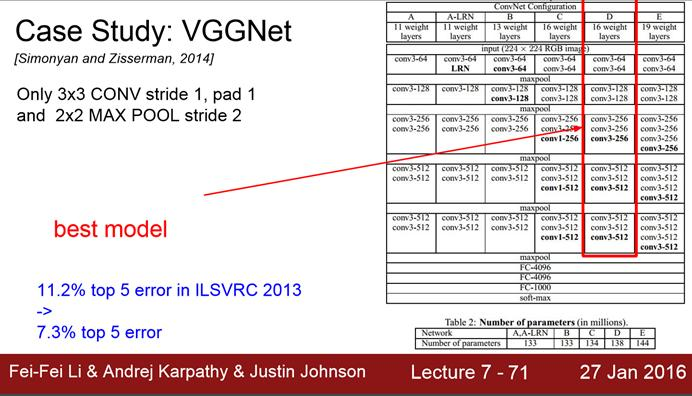

In [2]:
Image("images/vgg_image1.jpg")

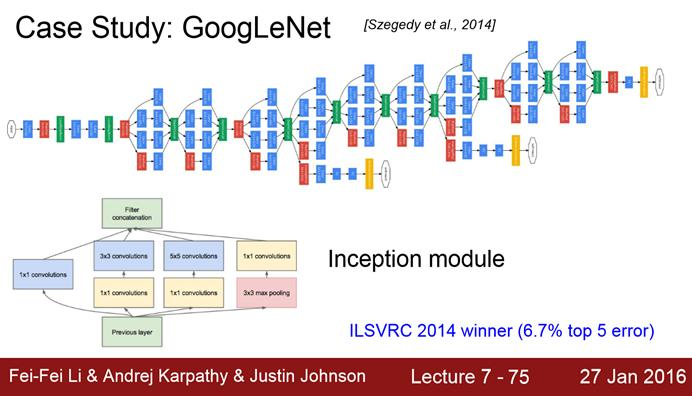

In [3]:
Image("images/vgg_image2.jpg")